# Project: Valuing real estate properties using machine learning

## Part 2: From data preparation to modeling

In [129]:
#Importings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [130]:
#Data loading
data = pd.read_csv("Properaty_data_clean.csv")

In [131]:
data.head()

,l2,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,price_period,property_type,operation_type
0,Buenos Aires,7.0,3.0,3.0,330.0,300.0,3000.0,Mensual,Casa,Alquiler
1,Buenos Aires,3.0,2.0,1.0,75.0,75.0,165000.0,Mensual,Otro,Venta
2,Capital Federal,1.0,2.0,3.0,265.0,265.0,600000.0,Mensual,Otro,Venta
3,Capital Federal,5.0,2.0,3.0,150.0,150.0,195000.0,Mensual,Otro,Venta
4,Capital Federal,1.0,2.0,1.0,80.0,80.0,155000.0,Mensual,Otro,Venta


In [132]:
data.shape

(97783, 10)

In [133]:
#Chech for NaN values:
data.isna().sum()

l2                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
price_period       0
property_type      0
operation_type     0
dtype: int64

### Data Preprocessing

In [134]:
X = data.drop("price", axis=1)
y = data.price

In [135]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3 , random_state=42) 

In [136]:
y_train.shape

(68448,)

In [137]:
y_test.shape

(29335,)

### Categorical values encoding

In [138]:
import category_encoders as ce

In [139]:
encoder = ce.CatBoostEncoder()

In [140]:
X_train_encoded = encoder.fit_transform(X_train, y_train)

In [141]:
X_train_encoded.head()

,l2,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,price_period,property_type,operation_type
71605,165263.681116,3.0,2.0,1.0,63.0,52.0,160000.0,165263.681116,165263.681116,165263.681116
71674,165263.681116,4.0,3.0,2.0,139.0,115.0,142000.0,162631.840558,165263.681116,162631.840558
15179,162631.840558,3.0,2.0,2.0,71.0,71.0,195000.0,155754.560372,162631.840558,155754.560372
36703,153631.840558,3.0,2.0,1.0,75.0,75.0,78000.0,165565.920279,153631.840558,165565.920279
9751,165263.681116,4.0,3.0,2.0,458.0,250.0,250000.0,148052.736223,128421.227039,148052.736223


In [142]:
X_test_encoded = encoder.transform(X_test, y_test)

In [143]:
X_test_encoded.head()

,l2,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,price_period,property_type,operation_type
13813,165263.681116,1.0,1.0,1.0,35.0,35.0,94000.0,165263.681116,165263.681116,165263.681116
85572,129631.840558,2.0,1.0,1.0,55.0,55.0,100000.0,129631.840558,129631.840558,129631.840558
20807,119754.560372,4.0,3.0,2.0,111.0,107.0,248000.0,119754.560372,165263.681116,119754.560372
92766,151815.920279,2.0,1.0,1.0,50.0,48.0,150000.0,151815.920279,119754.560372,151815.920279
80069,151452.736223,1.0,1.0,1.0,27.0,25.0,75000.0,151452.736223,127315.920279,151452.736223


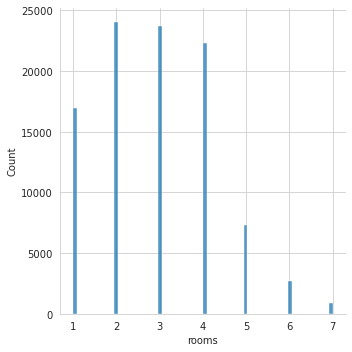

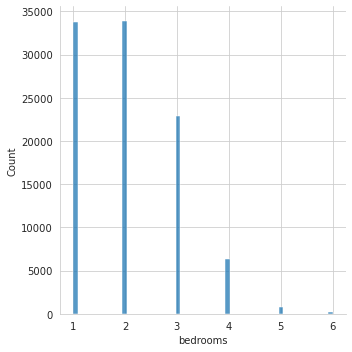

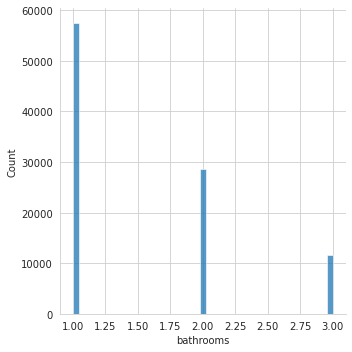

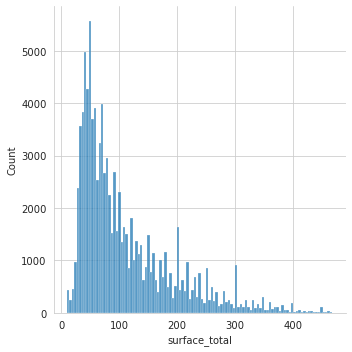

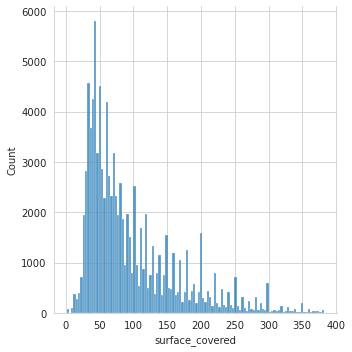

In [144]:
#Are ther non-gaussian variables?

variables = ["rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered"]

for var in variables:
    sns.displot(data=data, x=var)

In [145]:
non_gaussian_vars = ["surface_total", "surface_covered"]

for var in non_gaussian_vars:
    X_train_encoded[var] = np.log(X_train_encoded[var])
    X_test_encoded[var] = np.log(X_test_encoded[var])

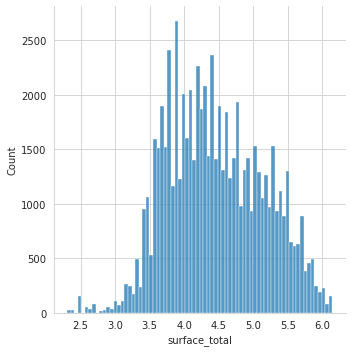

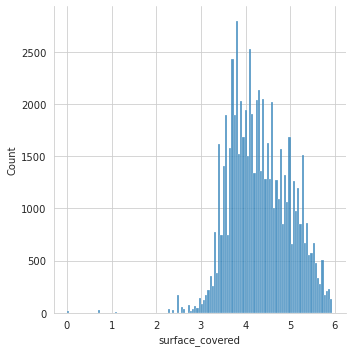

In [146]:
for var in non_gaussian_vars:
    sns.displot(data=X_train_encoded, x=var)

### Feature scaling

In [147]:
train_vars = [var for var in X_train_encoded.columns if var not in ["price"]]

In [148]:
scaler = StandardScaler()

In [149]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded[train_vars]), columns=X_train_encoded[train_vars].columns.tolist())

In [150]:
X_test_scaled = scaler.transform(X_test_encoded[train_vars])

### Feature selection

In [151]:
sel_ = SelectFromModel(Lasso(alpha=0.005, random_state=42))
sel_.fit(X_train_scaled, y_train)

SelectFromModel(estimator=Lasso(alpha=0.005, random_state=42))

In [152]:
selected_features = X_train_scaled.columns[(sel_.get_support())]

In [153]:
print('Total features: {}'.format((X_train_scaled.shape[1])))
print('selected features: {}'.format(len(selected_features)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_== 0)))

Total features: 9
selected features: 9
features with coefficients shrank to zero: 0


In [154]:
selected_features

Index(['l2', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price_period', 'property_type', 'operation_type'],
      dtype='object')

## Target distribution

In [155]:
y_train

71605    160000.0
71674    142000.0
15179    195000.0
36703     78000.0
9751     250000.0
           ...   
6265      96000.0
54886    250000.0
76820     90000.0
860       60000.0
15795     43000.0
Name: price, Length: 68448, dtype: float64

In [156]:
pt = PowerTransformer(method='yeo-johnson')
y_train_trans = pt.fit_transform(y_train.values.reshape(-1,1))

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

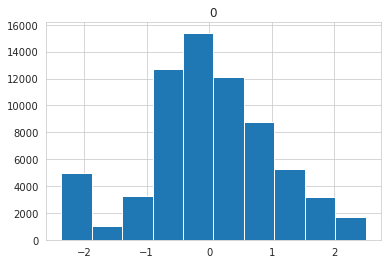

In [157]:
pd.DataFrame(y_train_trans).hist()

In [158]:
y_test_trans = pt.transform(y_test.values.reshape(-1,1))

### Building models

### Random Forest 

In [34]:
RF_model = RandomForestRegressor(random_state=42)

In [89]:
param_grid = {"n_estimators": [10,20,40,60,70,100,400],
               "max_depth": [50,100,150,200,450,750,1000],
               "max_features": ["auto", "sqrt", "log2"],
               "bootstrap": [True, False]}

In [90]:
RF_grid = GridSearchCV(estimator=RF_model, param_grid=param_grid, cv=10, n_jobs=-1,  scoring="neg_mean_squared_error") 

In [91]:
RF_grid.fit(X_train_scaled, y_train_trans)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [50, 100, 150, 200, 450, 750, 1000],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 20, 40, 60, 70, 100, 400]},
             scoring='neg_mean_squared_error')

In [92]:
from joblib import dump, load
dump(RF_grid, 'RF_gs_properati.joblib')

['RF_gs_properati.joblib']

In [94]:
RF_grid.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'sqrt',
 'n_estimators': 400}

In [95]:
y_test_pred_rf = RF_grid.predict(X_test_scaled)
y_train_pred_rf = RF_grid.predict(X_train_scaled)

In [99]:
### CALCULAMOS EL ERROR
rmse_train_rf = np.sqrt(mean_squared_error(y_train_trans, y_train_pred_rf))
rmse_test_rf = np.sqrt(mean_squared_error(y_test_trans, y_test_pred_rf))

In [100]:
print(f'Raíz del error cuadrático medio en Train: {rmse_train_rf}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test_rf}')
r2_rf = r2_score(y_test_trans, y_test_pred_rf)
print('R2:' ,r2_rf)

Raíz del error cuadrático medio en Train: 0.29539147597283855
Raíz del error cuadrático medio en Test: 0.8316931962753735
R2: 0.31358321085787844


In [ ]:
### Using gpu


### Extra Tree Regressor

In [35]:
X_train_scaled.shape

(67139, 8)

In [36]:
from sklearn.ensemble import ExtraTreesRegressor

In [37]:
et = ExtraTreesRegressor(random_state=42)

In [38]:
param_grid_et = {
    "n_estimators" : [5, 10, 50, 100, 500, 1000, 5000],
    "max_features" : [x for x in range(1, 9)],
    "min_samples_split" : [x for x in range(2,15)],
    "bootstrap" : [True, False]
    
}

In [43]:
et_grid = RandomizedSearchCV(estimator=et,param_distributions=param_grid_et, cv=10, n_jobs=-1,  scoring="neg_mean_squared_error" )

In [44]:
et_grid.fit(X_train_scaled, y_train_trans)

RandomizedSearchCV(cv=10, estimator=ExtraTreesRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7,
                                                         8],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14],
                                        'n_estimators': [5, 10, 50, 100, 500,
                                                         1000, 5000]},
                   scoring='neg_mean_squared_error')

In [45]:
et_grid.best_params_

{'n_estimators': 5000,
 'min_samples_split': 10,
 'max_features': 7,
 'bootstrap': True}

In [46]:
y_test_pred_et = et_grid.predict(X_test_scaled)
y_train_pred_et = et_grid.predict(X_train_scaled)

In [47]:
### CALCULAMOS EL ERROR
rmse_train_et = np.sqrt(mean_squared_error(y_train_trans, y_train_pred_et))
rmse_test_et = np.sqrt(mean_squared_error(y_test_trans, y_test_pred_et))

In [48]:
print(f'Raíz del error cuadrático medio en Train: {rmse_train_et}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test_et}')
r2_et = r2_score(y_test_trans, y_test_pred_et)
print('R2:' ,r2_et)

Raíz del error cuadrático medio en Train: 0.5993518669423352
Raíz del error cuadrático medio en Test: 0.8166110861502474
R2: 0.33825275330014126


## LightGBM

In [159]:
import lightgbm as lgb

In [160]:
params = {
    "num_leaves" : [5,10,20,30, 40],
    "feature_fraction" : [0.0001, 0.001, 0.01, 0.1, 1.0],
    "max_depth" : [int(x) for x in range(1,11)],
    "min_data_in_leaf" : [5, 10, 15, 20, 25],
    "min_sum_hessian_in_leaf" : [10,20,30,40,50],
    "learning_rate" : [0.0001, 0.001, 0.01, 1.0],
    "n_estimators" : [10, 50, 100, 500, 1000, 5000],
    
}


In [161]:
model = lgb.LGBMRegressor(random_state=42, silent=True, extra_trees=True)

In [162]:
lgbm_rs = RandomizedSearchCV(estimator=model, param_distributions=params, cv=10, n_jobs=-1, scoring="neg_mean_squared_error")

In [163]:
lgbm_rs.fit(X_train_scaled, y_train_trans)

[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=50, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=50


RandomizedSearchCV(cv=10,
                   estimator=LGBMRegressor(extra_trees=True, random_state=42),
                   n_jobs=-1,
                   param_distributions={'feature_fraction': [0.0001, 0.001,
                                                             0.01, 0.1, 1.0],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          1.0],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'min_data_in_leaf': [5, 10, 15, 20, 25],
                                        'min_sum_hessian_in_leaf': [10, 20, 30,
                                                                    40, 50],
                                        'n_estimators': [10, 50, 100, 500, 1000,
                                                         5000],
                                        'num_

In [164]:
lgbm_rs.best_params_

{'num_leaves': 20,
 'n_estimators': 1000,
 'min_sum_hessian_in_leaf': 50,
 'min_data_in_leaf': 15,
 'max_depth': 8,
 'learning_rate': 1.0,
 'feature_fraction': 0.01}

In [165]:
y_test_pred_lgbm = lgbm_rs.predict(X_test_scaled)
y_train_pred_lgbm = lgbm_rs.predict(X_train_scaled)

In [166]:
### CALCULAMOS EL ERROR
rmse_train_lgbm = np.sqrt(mean_squared_error(y_train_trans, y_train_pred_lgbm))
rmse_test_lgbm = np.sqrt(mean_squared_error(y_test_trans, y_test_pred_lgbm))

In [167]:
print(f'Raíz del error cuadrático medio en Train: {rmse_train_lgbm}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test_lgbm}')
r2_lgbm = r2_score(y_test_trans, y_test_pred_lgbm)
print('R2:' ,r2_lgbm)

Raíz del error cuadrático medio en Train: 0.8810149774890936
Raíz del error cuadrático medio en Test: 0.9028656500025575
R2: 0.19632881708302496


In [168]:
np.any(np.isnan(y_test_pred_lgbm))

False

In [170]:
y_test_pred_lgbm_inv = pt.inverse_transform(y_test_pred_lgbm.reshape(-1,1))
y_test_inv = pt.inverse_transform(y_test_trans)

In [171]:
np.any(np.isnan(y_test_pred_lgbm_inv))

False

In [172]:
np.all(np.isfinite(y_test_pred_lgbm_inv))

True

In [173]:
rmse_test_lgbm = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_lgbm_inv))

In [174]:
rmse_test_lgbm

106183.31389280426

In [175]:
r2_lgbm = r2_score(y_test_inv, y_test_pred_lgbm_inv)
r2_lgbm

0.2566667879644574